## Imports

In [7]:
## Imports
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec

from keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Embedding, TimeDistributed, Bidirectional,GlobalMaxPooling1D


!git clone -s https://github.com/mstauffer/tcdf_text_classification.git
from tcdf_text_classification.iob_transformer import iob_transformer

!pip install -U gensim
from gensim.models import Word2Vec

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

!pip install seqeval
from seqeval.metrics import f1_score, classification_report, precision_score, recall_score, accuracy_score
! pip install plot_keras_history
from plot_keras_history import plot_history
!pip install tf2crf
from tf2crf import CRF, ModelWithCRFLoss, ModelWithCRFLossDSCLoss
from keras.optimizers import Adam

from sklearn.model_selection import KFold

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

[nltk_data] Downloading package punkt to /home/alilim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


fatal: destination path 'tcdf_text_classification' already exists and is not an empty directory.
Requirement already up-to-date: gensim in ./.local/lib/python3.8/site-packages (4.2.0)
  Using cached tensorflow-2.10.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)


In [3]:
import keras_tuner as kt
from keras_tuner.tuners import Hyperband

2022-11-14 11:12:46.684987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 11:12:47.134816: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-14 11:12:47.266946: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 11:12:48.746209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Dados

In [4]:
import pandas as pd

df = pd.read_csv('DODFCorpus_contratos_licitacoes_v2.csv')

df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis =1)

df['texto'] = df['texto'].str.replace(r'([A-Za-z]:)[0-9]', r'\1 ', regex=True)

In [5]:
data = df.query("tipo_rel == 'REL_EXTRATO_CONVENIO'")

In [8]:
# Extração dos IOBs
def split_data(dset):
  iob_v = iob_transformer('id_ato', 'texto', 'tipo_ent', keep_punctuation=True, return_df=False)

  acts, labels = iob_v.transform(dset)

  x_train, x_test, y_train, y_test = train_test_split(acts,labels, train_size=0.8, random_state=1)

  x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, train_size=0.5, random_state=1)

  return x_train, y_train, x_test, y_test, x_val, y_val

train_acts = []
train_labels = []

test_acts = []
test_labels = []

val_acts = []
val_labels = []

aux = data.tipo_rel.unique()

for d in aux:
  q = "tipo_rel == " + "'" + str(d) + "'"
  tr_acts, tr_labels, te_acts, te_labels, v_acts, v_labels = split_data(data.query(q))

  train_acts.extend(tr_acts)
  train_labels.extend(tr_labels)

  test_acts.extend(te_acts)
  test_labels.extend(te_labels)

  val_acts.extend(v_acts)
  val_labels.extend(v_labels)


def remove_wrong_tags(label_list):
  for label in label_list:
    for idx,w in enumerate(label):
      if w in ['B-11','B-12','B-50']:
        label[idx] = 'O'

remove_wrong_tags(train_labels)
remove_wrong_tags(test_labels)
remove_wrong_tags(val_labels)

iob = iob_transformer('id_ato', 'texto', 'tipo_ent', keep_punctuation=True, return_df=False)
iob_data = iob_transformer('id_ato', 'texto', 'tipo_ent', keep_punctuation=True, return_df=True)
acts, labels = iob.transform(data)

remove_wrong_tags(labels)

df_iob = iob_data.transform(data)

df_iob
df_iob.loc[df_iob.Word == 'B-11','Tag']='O'
df_iob.loc[df_iob.Word == 'B-12','Tag']='O'
df_iob.loc[df_iob.Word == 'B-50','Tag']='O'
#salvando todas as palavras do corpus sem repetição
words = set()

for act in acts:
    for word in act:
        words.add(word)
#convertendo o set em uma lista
words = list(words)

words.append("ENDPAD")
words.append("UNK")

words_amt = len(words)
tags = set()

for label in labels:
    for tag in label:
        tags.add(tag)
tags = list(tags)
tags_amt = len(tags)


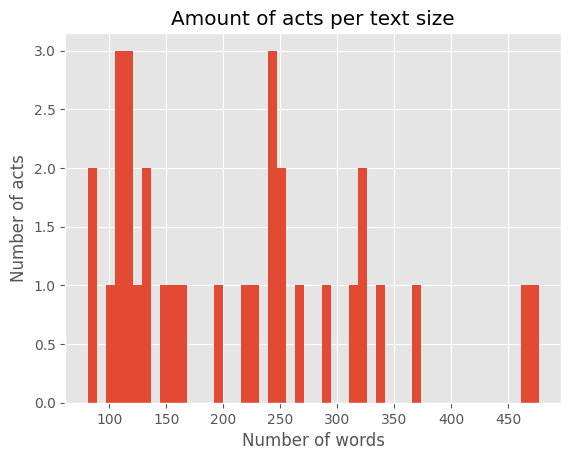

In [9]:
# Transformando os valores dos dados (representação inteira)
vocab = {}

for i in range(0,len(acts)):
    for word in acts[i]:
        if word.lower() not in vocab:
            vocab[word.lower()] = 1
        else:
            vocab[word.lower()]+=1
#dicionario das palavras com seu respectivo valor inteiro
lab_enc = LabelEncoder()

lab_enc.fit(words)
words_i = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))

i_words = {}

for key in words_i:
  i_words[words_i[key]] = key

#i_words
lab_enc = LabelEncoder()

lab_enc.fit(tags)
tags_i = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))


i_tags = {}

for key in tags_i:
  i_tags[tags_i[key]] = key

i_tags
#Padding
plt.hist([len(ato) for ato in acts], bins=50)

plt.xlabel("Number of words")
plt.ylabel("Number of acts")
plt.title("Amount of acts per text size")
plt.show()
def transform_data(x,y):
  X,Y = [],[]

  for act in x:
    aux = []
    for word in act:
      aux.append(words_i[word])
    X.append(aux)

  for label in y:
    aux = []
    for word in label:
      aux.append(tags_i[word])
    Y.append(aux)

  return X,Y
x_train,y_train = transform_data(train_acts,train_labels)

x_test, y_test = transform_data(test_acts,test_labels)

x_val, y_val = transform_data(val_acts,val_labels)

x_train = pad_sequences(maxlen=400, sequences=x_train, padding="post", value=words_i['ENDPAD'])
x_test = pad_sequences(maxlen=400, sequences=x_test, padding="post", value=words_i['ENDPAD'])
x_val = pad_sequences(maxlen=400, sequences=x_val, padding="post", value=words_i['ENDPAD'])

y_train = pad_sequences(maxlen=400, sequences=y_train, padding="post", value=tags_i["O"])
y_test = pad_sequences(maxlen=400, sequences=y_test, padding="post", value=tags_i["O"])
y_val = pad_sequences(maxlen=400, sequences=y_val, padding="post", value=tags_i["O"])

In [10]:
from tensorflow.keras.models import load_model

## Keras HP Tuner

In [11]:
def convert_values(index_array,y_test):
  pred_tags = []
  real_tags = []

  for act in index_array:
    act_tags = []
    for w in act:
      act_tags.append(i_tags[w])
    pred_tags.append(act_tags)

  for ato in y_test:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(i_tags[palavra])
    real_tags.append(tags_ato)

  return real_tags, pred_tags

In [15]:
def build_model(tuner):

  ptm =load_model('models/contratos/lstm_f5.h5')

  model = Sequential()

  for layer in ptm.layers:
      layer.trainable = False

  model.add(ptm)

  model.add(LSTM(100, return_sequences=True))
  model.add(Dropout(0.5))
  lr = tuner.Choice("learning_rate", values=[0.0001, 0.001, 0.01, 0.1, 0.009, 0.0095, 0.0000001])

  adam = Adam(learning_rate=lr)

  model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model

In [13]:
early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False)

In [20]:
print("Instantiating a random search tuner object...")
tuner = kt.Hyperband(build_model, objective="val_accuracy", max_epochs=30, factor=3, seed=42)

Instantiating a random search tuner object...
INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [21]:
tuner.search(x_train, y_train, validation_data=(x_val, y_val), batch_size=15, callbacks=[early_stopping], epochs=20)

INFO:tensorflow:Oracle triggered exit


In [22]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

In [23]:
bestHP.get("learning_rate")

0.1

## Transfer learning (LSTM)

In [21]:
import keras

In [175]:
tf.keras.backend.clear_session()

In [165]:
tf.config.run_functions_eagerly(True)

In [180]:
ptm =load_model('/home/alilim/models/lstm_f3.h5')

for layer in ptm.layers:
  layer.trainable = False 

model = Sequential()

for layer in ptm.layers[:-1]:
  model.add(layer)

model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.7))
model.add(Dense(tags_amt, activation="softmax"))

In [181]:
def get_f1(y_true, y_pred): #taken from old keras source code
    
    y_pred = np.argmax(y_pred, axis=-1)
    real_tags,pred_tags=convert_values(y_pred,y_true.numpy())

    f1 = f1_score(real_tags,pred_tags)

    return f1

In [213]:
adam = Adam(learning_rate = 0.00001)

model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [214]:
early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False)

In [216]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=9, callbacks=[early_stopping], epochs=15)

Epoch 1/15
3/3 [==============================] - 12s 4s/step - loss: 0.7556 - accuracy: 0.8012 - val_loss: 0.7084 - val_accuracy: 0.7925
Epoch 2/15
3/3 [==============================] - 12s 4s/step - loss: 0.7516 - accuracy: 0.8120 - val_loss: 0.7084 - val_accuracy: 0.7925
Epoch 3/15
3/3 [==============================] - 12s 4s/step - loss: 0.7555 - accuracy: 0.8059 - val_loss: 0.7084 - val_accuracy: 0.7925
Epoch 4/15
3/3 [==============================] - 14s 5s/step - loss: 0.7439 - accuracy: 0.8131 - val_loss: 0.7084 - val_accuracy: 0.7925
Epoch 5/15
3/3 [==============================] - 14s 5s/step - loss: 0.7516 - accuracy: 0.8069 - val_loss: 0.7085 - val_accuracy: 0.7925
Epoch 6/15
3/3 [==============================] - 13s 4s/step - loss: 0.7493 - accuracy: 0.8076 - val_loss: 0.7085 - val_accuracy: 0.7925
Epoch 7/15
3/3 [==============================] - 13s 5s/step - loss: 0.7453 - accuracy: 0.8131 - val_loss: 0.7085 - val_accuracy: 0.7931
Epoch 8/15
3/3 [==================

In [217]:
pred = model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [218]:
pred = np.argmax(pred, axis=-1)

In [219]:
real_tags, pred_tags = convert_values(pred,y_test)

In [220]:
f1_score(real_tags,pred_tags)

0.0

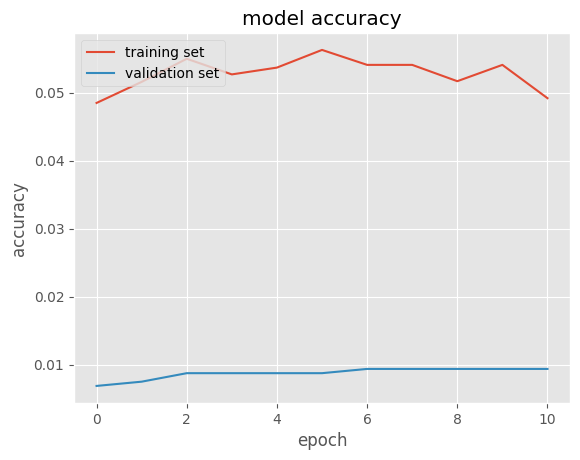

In [100]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

## Retreinamento do modelo de contratos (LSTM)

In [8]:
import keras
tf.keras.backend.clear_session()


In [9]:
ptm =load_model('/home/alilim/models/lstm_f3.h5')

2022-11-12 16:29:39.300148: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-12 16:29:39.300277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thorin): /proc/driver/nvidia/version does not exist
2022-11-12 16:29:39.301383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
ptm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 100)          2426700   
                                                                 
 lstm_3 (LSTM)               (None, 400, 100)          80400     
                                                                 
 dropout_3 (Dropout)         (None, 400, 100)          0         
                                                                 
 dense_3 (Dense)             (None, 400, 35)           3535      
                                                                 
Total params: 2,510,635
Trainable params: 83,935
Non-trainable params: 2,426,700
_________________________________________________________________


In [12]:
history = ptm.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=25, epochs=45)

Epoch 1/45
1/1 [==============================] - 5s 5s/step - loss: 14.1715 - accuracy: 6.0000e-04 - val_loss: 6.5728 - val_accuracy: 0.0019
Epoch 2/45
1/1 [==============================] - 0s 459ms/step - loss: 6.9758 - accuracy: 0.0012 - val_loss: 3.7566 - val_accuracy: 0.0025
Epoch 3/45
1/1 [==============================] - 0s 429ms/step - loss: 4.4138 - accuracy: 0.0015 - val_loss: 2.4779 - val_accuracy: 0.5813
Epoch 4/45
1/1 [==============================] - 1s 691ms/step - loss: 3.3090 - accuracy: 0.0807 - val_loss: 1.6586 - val_accuracy: 0.6463
Epoch 5/45
1/1 [==============================] - 1s 594ms/step - loss: 2.4286 - accuracy: 0.3507 - val_loss: 1.1550 - val_accuracy: 0.7613
Epoch 6/45
1/1 [==============================] - 0s 479ms/step - loss: 1.7445 - accuracy: 0.5673 - val_loss: 0.8604 - val_accuracy: 0.8075
Epoch 7/45
1/1 [==============================] - 0s 409ms/step - loss: 1.2470 - accuracy: 0.7169 - val_loss: 0.7920 - val_accuracy: 0.8163
Epoch 8/45
1/1 [==

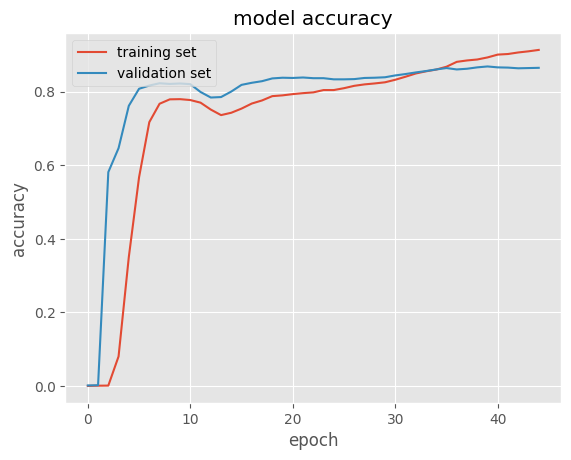

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

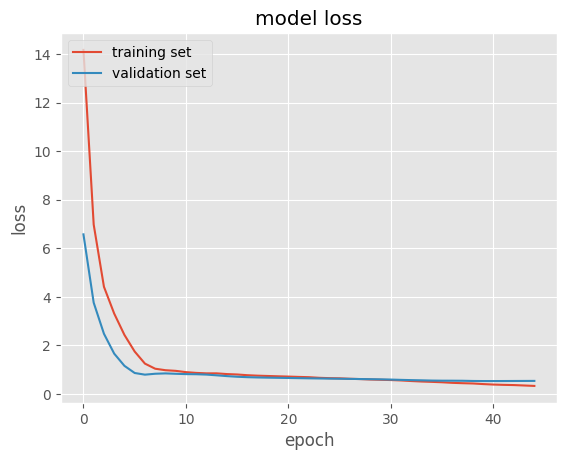

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [16]:
pred = ptm.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [17]:
pred = np.argmax(pred, axis=-1)

In [20]:
real_tags, pred_tags = convert_values(pred,y_test)

KeyError: 34